# Desafio LATAM

### Librerías

In [1]:
# instalar librerias
%pip install pandas
%pip install matplotlib
%pip install -U scikit-learn
%pip install xgboost
%pip install optuna

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Requirement already up-to-date: scikit-learn in /home/joe/.local/lib/python3.8/site-packages (1.1.2)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [90]:
%pip install lightgbm

     |████████████████████████████████| 2.0 MB 15.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Calidad de los datos

In [92]:
# importar librerias
import numpy as np
import pandas as pd
import time
import lightgbm as lgb
import optuna
from sklearn.metrics import classification_report, accuracy_score

pd.set_option('display.max_columns', 500)

### Carga de datos

In [3]:
# cargar data y echar vistazo a datos
df = pd.read_csv('data/dataset_SCL.csv')
df.head()

<ipython-input-3-769d1d528a22>:2: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/dataset_SCL.csv')


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [4]:
# chequear tipo de datos
df.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

In [5]:
# existen filas duplicadas?
df.duplicated().any()

False

In [6]:
# shape
df.shape

(68206, 18)

In [7]:
# columnas con valores no definidos
df.isna().any()

Fecha-I      False
Vlo-I        False
Ori-I        False
Des-I        False
Emp-I        False
Fecha-O      False
Vlo-O         True
Ori-O        False
Des-O        False
Emp-O        False
DIA          False
MES          False
AÑO          False
DIANOM       False
TIPOVUELO    False
OPERA        False
SIGLAORI     False
SIGLADES     False
dtype: bool

* Existen valores no definidos en columna `Vlo-O`. ¿Cuantos serán?

In [8]:
df['Vlo-O'].isna().sum()

1

### Liempieza de datos

* Cambiar tipo de datos de columna: \
    `- Fecha-I      timestamp` \
    `- Vlo-I        int` \
    `- Ori-I        object` \
    `- Des-I        object` \
    `- Emp-I        object` \
    `- Fecha-O      timestamp` \
    `- Vlo-O         int` \
    `- Ori-O        object` \
    `- Des-O        object` \
    `- Emp-O        object` \
    `- DIA          int` \
    `- MES          int` \
    `- AÑO          int` \
    `- DIANOM       object` \
    `- TIPOVUELO    object` \
    `- OPERA        object` \
    `- SIGLAORI     object` \
    `- SIGLADES     object` 
    
* Quitar fila sin dato en columna `Vlo-O`. Tambien quitar filas relacionadas con ésta, de forma que no tenga impacto en analisis

In [9]:
# crear copia
df_clean = df.copy()

In [10]:
# df_clean[df_clean[['Fecha-I', 'Vlo-I']].duplicated(keep=False)].sort_values(by=['Fecha-I', 'Vlo-I'])

In [11]:
# cambio de tipo de datos
df_clean = df.copy()
df_clean['Fecha-I'] = pd.to_datetime(df_clean['Fecha-I'])
df_clean['Fecha-O'] = pd.to_datetime(df_clean['Fecha-O'])
# df_clean['Vlo-I'].astype('int')

In [12]:
df_clean.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

* Cambiar `Vlo-I` y `Vlo-O` a `int`

In [13]:
df_clean['Vlo-I'] = df_clean['Vlo-I'].astype(int)

ValueError: invalid literal for int() with base 10: '989P'

* Identificar strings que no se pueden convertir a int

In [14]:
df_clean['Vlo-I'].to_list()

num_buenos = []
num_malos = []
for i, vlo_i_i in enumerate(df_clean['Vlo-I'].to_list()):
    try:
        num_buenos.append(int(vlo_i_i))
    except:
        num_malos.append(vlo_i_i)          
print(len(num_buenos))

68201


In [15]:
print(num_malos)

['989P', '940P', '591P', '846A', '1104A']


* Existen numeros con character. ¿Será un error de tipeo? Para validar esto se quitará el ultimo char en las filas de estos casos y se comparara versus el resto del dataset para ver si se duplican filas. En caso de no duplicarse filas significa que fue un error de tipeo

In [16]:
# seleccionar dataset con char
df_clean_w_char = df_clean[df_clean['Vlo-I'].isin(num_malos)].copy()

# quitarles ultimo caracter 
df_clean_w_char['Vlo-I'] = df_clean_w_char['Vlo-I'].str[:-1] # quitarles ultimo caracter 
df_clean_w_char

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
22232,2017-05-13 21:50:00,989,SCEL,SUMU,AAL,2017-05-13 21:52:00,989,SCEL,SUMU,AAL,13,5,2017,Sabado,I,American Airlines,Santiago,Montevideo
27464,2017-06-16 20:30:00,940,SCEL,KDFW,AAL,2017-06-16 20:50:00,940,SCEL,KDFW,AAL,16,6,2017,Viernes,I,American Airlines,Santiago,Dallas
39225,2017-08-07 19:00:00,591,SCEL,LFPG,PUE,2017-08-07 20:35:00,591P,SCEL,LFPG,PUE,7,8,2017,Lunes,I,Plus Ultra Lineas Aereas,Santiago,Paris
39266,2017-08-24 23:00:00,846,SCEL,KIAH,UAL,2017-08-24 23:00:00,2804,SCEL,KIAH,UAL,24,8,2017,Jueves,I,United Airlines,Santiago,Houston
58126,2017-11-05 17:00:00,1104,SCEL,SCSE,SKU,2017-11-05 17:42:00,1104,SCEL,SCSE,SKU,5,11,2017,Domingo,N,Sky Airline,Santiago,La Serena


In [17]:
# seleccionar el complemento
# quitarles ultimo caracter 
df_complement = df_clean[~df_clean['Vlo-I'].isin(num_malos)].copy()

In [18]:
# cuadratura
df_complement.shape, df_clean_w_char.shape, df.shape

((68201, 18), (5, 18), (68206, 18))

In [19]:
df_append = pd.concat([df_complement, df_clean_w_char])

In [20]:
df_append.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


In [21]:
df_append.duplicated().any()

False

* Al quitar ultimo char y volver a concatenar resultados no hay filas duplicadas. Los datos quedan limpios. Se puede volver a limpiar las columnas

In [22]:
df_append.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

In [23]:
df_append['Vlo-I'] = df_append['Vlo-I'].astype('int')

* Repetir proceso para columna `Vlo-O`

In [24]:
df_append['Vlo-O'].to_list()

num_buenos = []
num_malos = []
for i, vlo_i_i in enumerate(df_append['Vlo-O'].to_list()):
    try:
        num_buenos.append(float(vlo_i_i))
    except:
        num_malos.append(vlo_i_i)          
# print(len(num_buenos))

In [25]:
num_malos

['71R',
 '71R',
 '201R',
 '71R',
 '43R',
 '401A',
 '401B',
 '802R',
 '114R',
 '622R',
 '492R',
 '338R',
 '846A',
 '502R',
 '207R',
 '591P']

In [26]:
# seleccionar dataset con char
df_clean_w_char = df_append[df_append['Vlo-O'].isin(num_malos)].copy()

# quitarles ultimo caracter 
df_clean_w_char['Vlo-O'] = df_clean_w_char['Vlo-O'].str[:-1] # quitarles ultimo caracter 
df_clean_w_char

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71,SCEL,SCIE,SKU,22,3,2017,Miercoles,N,Sky Airline,Santiago,Concepcion
17055,2017-03-22 10:00:00,201,SCEL,SCIE,LXP,2017-03-22 11:50:00,201,SCEL,SCIE,LXP,22,3,2017,Miercoles,N,Grupo LATAM,Santiago,Concepcion
19207,2017-04-25 09:00:00,71,SCEL,SCIE,SKU,2017-04-25 09:29:00,71,SCEL,SCIE,SKU,25,4,2017,Martes,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
22301,2017-05-26 09:40:00,401,SCEL,LFPG,AFR,2017-05-26 10:03:00,401,SCEL,LFPG,AFR,26,5,2017,Viernes,I,Air France,Santiago,Paris
22302,2017-05-28 09:40:00,401,SCEL,LFPG,AFR,2017-05-28 09:43:00,401,SCEL,LFPG,AFR,28,5,2017,Domingo,I,Air France,Santiago,Paris
24304,2017-05-11 10:00:00,802,SCEL,SPJC,SKU,2017-05-11 10:36:00,802,SCEL,SPJC,SKU,11,5,2017,Jueves,I,Sky Airline,Santiago,Lima
27246,2017-05-15 12:15:00,114,SCEL,SCAT,LAN,2017-05-15 13:10:00,114,SCEL,SCAT,LAN,15,5,2017,Lunes,N,Grupo LATAM,Santiago,Copiapo
27247,2017-05-25 13:15:00,622,SCEL,MMMX,LAN,2017-05-25 13:23:00,622,SCEL,MMMX,LAN,25,5,2017,Jueves,I,Grupo LATAM,Santiago,Ciudad de Mexico


In [27]:
# seleccionar el complemento
# quitarles ultimo caracter 
df_complement = df_append[~df_append['Vlo-O'].isin(num_malos)].copy()

In [28]:
# cuadratura
df_complement.shape, df_clean_w_char.shape, df.shape

((68190, 18), (16, 18), (68206, 18))

In [29]:
df_append_2 = pd.concat([df_complement, df_clean_w_char])

In [30]:
df_append_2.duplicated().any()

False

In [31]:
df_append_2['Vlo-O'] = df_append_2['Vlo-O'].astype('int')

ValueError: cannot convert float NaN to integer

In [32]:
# quitar dato con NaN
df_append_2.dropna(inplace=True)

In [33]:
# pasar datos a float primero
df_append_2['Vlo-O'] = df_append_2['Vlo-O'].astype('float')

In [34]:
# luego a int
df_append_2['Vlo-O'] = df_append_2['Vlo-O'].astype('int')

In [35]:
# chequear tipo de datos
df_append_2.dtypes

Fecha-I      datetime64[ns]
Vlo-I                 int64
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                 int64
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

In [36]:
# comparacion datasets
df_append_2.duplicated().any(), df_append_2.shape

(False, (68205, 18))

In [37]:
df.duplicated().any(), df.shape

(False, (68206, 18))

* Terminamos con un dataframe con los tipos de datos propuestos y con una fila menos, que es aquella que tiene valor nulo en la columna `Vlo-O`.
* Fin de la limpieza de datos. Comienzo de analisis

## Analisis de datos 
* Ahora que se han limpiado los datos se procede a análisis de estos

In [38]:
dataset = df_append_2.copy()

In [39]:
dataset.dtypes

Fecha-I      datetime64[ns]
Vlo-I                 int64
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                 int64
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int64
MES                   int64
AÑO                   int64
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

In [40]:
dataset.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami


* Se asume que para un vuelo programado para una fecha debería haber una única fila 

In [41]:
dataset.groupby(['Fecha-I', 'Vlo-I'])['Fecha-O'].count().describe()

count    68188.000000
mean         1.000249
std          0.015788
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: Fecha-O, dtype: float64

* Existen registros con la misma fecha y número de vuelo pero con 2 fechas de operación. Esto no es factible, ya que para un vuelo programado (fecha y numero de vuelo) se realiza un unico vuelo real (operado)
* Cuando esto pasa se asume que el vuelo operado mas tarde es el que efectivamente se realizó

In [42]:
dataset_last_op = dataset.loc[dataset.groupby(['Fecha-I', 'Vlo-I'])['Fecha-O'].idxmax()]

In [43]:
dataset_last_op.shape

(68188, 18)

* Finalmente el dataset de interes es de 68188 registros, vs los 68206 originales. Lo anterior implica escartar 18 registros del dataset cargado
* Con lo anterior nos aseguramos que cada fila corresponde a un vuelo

### 1. Descripcion general de los datos
* Aplicar metodo `describe()` sobre el dataset ya seleccionado

In [44]:
dataset_last_op.describe()

,Vlo-I,Vlo-O,DIA,MES,AÑO
count,68188.000000,68188.000000,68188.000000,68188.000000,68188.000000
mean,970.050507,967.643676,15.715170,6.622969,2017.000029
std,2029.245953,2026.414637,8.782725,3.523572,0.005416
min,1.000000,1.000000,1.000000,1.000000,2017.000000
25%,150.000000,150.000000,8.000000,3.000000,2017.000000
50%,300.000000,300.000000,16.000000,7.000000,2017.000000
75%,634.000000,638.000000,23.000000,10.000000,2017.000000
max,9956.000000,9956.000000,31.000000,12.000000,2018.000000


* Llama la atencion que los datos sean solo hasta el 2018
* Dias y meses normales
* `Vlo-I` y `Vlo-O` no son correlativos por `Fecha-I`


### Preguntas:

1. ¿Cuantos vuelos se programan a la misma hora?
2. ¿Cual es la proporcion de vuelos nacionales sobre internacionales?
3. ¿Como ha ido evolucionando el numero de vuelos en los últimos 2 años por mes?
4. ¿Como ha variado la proporcion de vuelos segun dia de la semana?
5. ¿Cual es la aerolinea que mas opera?

**1. ¿Cuantos vuelos se programan a la misma hora?** 

In [45]:
# contar segun fecha programada la cantidad de numeros de vuelos distintos que hay
dataset_last_op.groupby(['Fecha-I'])['Vlo-I'].nunique().value_counts()

1    40995
2     9944
3     1979
4      305
5       26
6        3
Name: Vlo-I, dtype: int64

* Quien pensaría que se programan hasta 6 vuelos a la misma hora

**2. ¿Cual es la proporcion de vuelos nacionales sobre internacionales?** \
**3. ¿Como ha ido evolucionando el numero de vuelos en los últimos 2 años por mes?**

In [46]:
# crear columna string que concatene mes y año
dataset_last_op['date'] = dataset_last_op['AÑO'].map(str)+ '-' +dataset_last_op['MES'].map(str)
dataset_last_op['date'] = pd.to_datetime(dataset_last_op['date'], format='%Y-%m').dt.strftime('%Y-%m')

In [47]:
dataset_last_op.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,date
169,2017-01-01 00:15:00,11,SCEL,MMMX,AMX,2017-01-01 00:04:00,11,SCEL,MMMX,AMX,1,1,2017,Domingo,I,Aeromexico,Santiago,Ciudad de Mexico,2017-01
5078,2017-01-01 01:15:00,572,SCEL,SKBO,LAN,2017-01-01 01:10:00,572,SCEL,SKBO,LAN,1,1,2017,Domingo,I,Grupo LATAM,Santiago,Bogota,2017-01


<AxesSubplot: xlabel='date'>

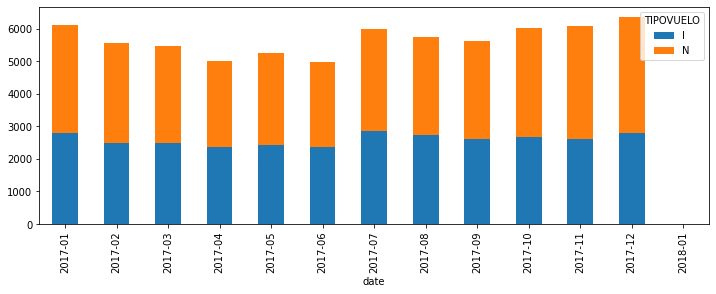

In [48]:
dataset_last_op.groupby(['date', 'TIPOVUELO'])['Fecha-I'].count().unstack('TIPOVUELO').plot(kind='bar', stacked=True, figsize=(12,4))

* La cantidad de vuelos se mantuvo relativamente estable entre los 5000 y 6000 vuelos en todo 2017, siendo los valores de mayor viaje Enero, Julio, Octubre, Noviembre y Diciembre
* En general la proporcion entre viajes nacionales e internacionales se mantiene estable en el tiempo, siendo ligeramente mayor la cantidad de vuelos nacionales por sobre los internacionales

**4. ¿Como ha variado la proporcion de vuelos segun dia de la semana?**

<AxesSubplot: xlabel='date'>

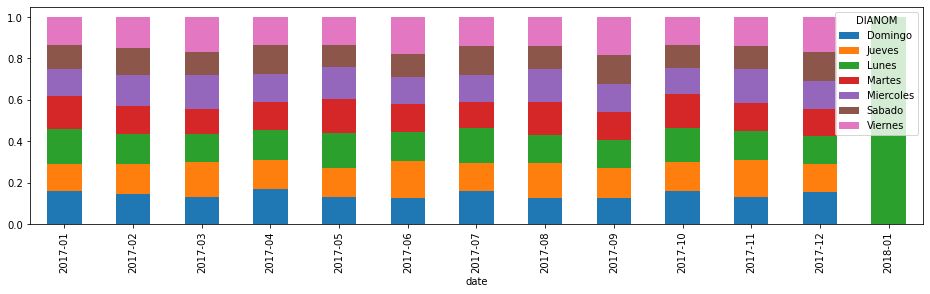

In [49]:
(dataset_last_op.groupby(['date', 'DIANOM'])['Fecha-I'].count()/dataset_last_op.groupby(['date'])['Fecha-I'].count()).unstack('DIANOM').plot(kind='bar', stacked=True, figsize=(16,4))

* En general no hay una tendencia o variabilidad fuerte en la preferencia para comprar en un día de la semana, dado un mes en particular

**5. ¿Cual es la aerolinea que mas opera?**

In [50]:
(dataset_last_op.groupby(['OPERA'])['Fecha-I'].count()*100/dataset_last_op.groupby(['OPERA'])['Fecha-I'].count().sum()).sort_values(ascending=False)

OPERA
Grupo LATAM                 59.953364
Sky Airline                 20.959700
Aerolineas Argentinas        2.858274
Copa Air                     2.713087
Latin American Wings         2.453511
Avianca                      1.689447
JetSmart SPA                 1.605854
Gol Trans                    1.182026
American Airlines            1.110166
Air Canada                   0.828592
Iberia                       0.530885
Delta Air                    0.525019
Air France                   0.525019
Aeromexico                   0.514753
United Airlines              0.491289
Oceanair Linhas Aereas       0.409163
Alitalia                     0.379832
K.L.M.                       0.368100
British Airways              0.300639
Qantas Airways               0.285974
Lacsa                        0.134921
Austral                      0.108523
Plus Ultra Lineas Aereas     0.071860
Name: Fecha-I, dtype: float64

* Lejos los operadores con mas vuelos son Grupo LATAM y SKy Airline, sumando un 80% de los vuelos programados

### 2. Nuevas variables

* Se crean variables nuevas `temporada_alta`, `dif_min`, `atraso_15` y `periodo_dia`.
* El nuevo dataset se exporta a `data/synthetic_features.csv`

In [51]:
df_final = dataset_last_op.copy()

In [52]:
# temporada alta
df_final['temporada_alta'] = 0
df_final.loc[(((df_final['DIA']>=1) & (df_final['MES']>=1)) & ((df_final['DIA']<=31) & (df_final['MES']<=3))), 'temporada_alta'] = 1
df_final.loc[(((df_final['DIA']>=5) & (df_final['MES']>=7)) & ((df_final['DIA']<=31) & (df_final['MES']<=7))), 'temporada_alta'] = 1
df_final.loc[(((df_final['DIA']>=11) & (df_final['MES']>=9)) & ((df_final['DIA']<=30) & (df_final['MES']<=9))), 'temporada_alta'] = 1
df_final.loc[(((df_final['DIA']>=11) & (df_final['MES']>=12)) & ((df_final['DIA']<=31) & (df_final['MES']<=12))), 'temporada_alta'] = 1

In [53]:
df_final['temporada_alta'].sum()

30513

* 30513 de 68188 vuelos se hacen en temporada alta

In [54]:
# dif_min
print(((df_final['Fecha-O'] - df_final['Fecha-I']).dt.total_seconds() <0).sum(),
((df_final['Fecha-O'] - df_final['Fecha-I']).dt.total_seconds() == 0).sum(),
((df_final['Fecha-O'] - df_final['Fecha-I']).dt.total_seconds() > 0).sum())

17903 4788 45497


* Hay algunos vuelos que salen antes de lo programado. Esto parece extraño.
* Dado que lo anterior podría ser extraño en términos de la calidad de servicio es que se prefiere quitar estos casos

In [55]:
df_final['dif_min'] = (df_final['Fecha-O'] - df_final['Fecha-I']).dt.total_seconds()/60

In [56]:
df_final = df_final[df_final['dif_min']>=0]

In [57]:
df_final['dif_min'].describe()

count    50285.000000
mean        13.719817
std         20.544061
min          0.000000
25%          3.000000
50%          7.000000
75%         16.000000
max        161.000000
Name: dif_min, dtype: float64

In [58]:
# atraso_15
df_final['atraso_15'] = 0
df_final.loc[(df_final['dif_min']>15), 'atraso_15'] = 1

In [59]:
print("Total de pedidos con atraso: {}".format(df_final['atraso_15'].sum()))

Total de pedidos con atraso: 12614


In [60]:
# periodo_dia
df_final['periodo_dia'] = 0
df_final.loc[(((df_final['Fecha-I'].dt.hour >=0) & (df_final['Fecha-I'].dt.minute >=0)) & ((df_final['Fecha-I'].dt.hour <=4) & (df_final['Fecha-I'].dt.minute <=59))), 'periodo_dia'] = 'noche'
df_final.loc[(((df_final['Fecha-I'].dt.hour >=5) & (df_final['Fecha-I'].dt.minute >=0)) & ((df_final['Fecha-I'].dt.hour <=11) & (df_final['Fecha-I'].dt.minute <=59))), 'periodo_dia'] = 'mañana'
df_final.loc[(((df_final['Fecha-I'].dt.hour >=12) & (df_final['Fecha-I'].dt.minute >=0)) & ((df_final['Fecha-I'].dt.hour <=18) & (df_final['Fecha-I'].dt.minute <=59))), 'periodo_dia'] = 'tarde'
df_final.loc[(((df_final['Fecha-I'].dt.hour >=19) & (df_final['Fecha-I'].dt.minute >=0)) & ((df_final['Fecha-I'].dt.hour <=23) & (df_final['Fecha-I'].dt.minute <=59))), 'periodo_dia'] = 'noche'

In [61]:
print(df_final['periodo_dia'].value_counts(),df_final['periodo_dia'].value_counts().sum())

tarde     19396
mañana    18590
noche     12299
Name: periodo_dia, dtype: int64 50285


In [62]:
df_final.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,date,temporada_alta,dif_min,atraso_15,periodo_dia
622,2017-01-01 01:23:00,495,SCEL,MPTO,CMP,2017-01-01 01:29:00,495,SCEL,MPTO,CMP,...,Domingo,I,Copa Air,Santiago,Ciudad de Panama,2017-01,1,6.0,0,noche
409,2017-01-01 01:33:00,240,SCEL,SKBO,AVA,2017-01-01 01:38:00,240,SCEL,SKBO,AVA,...,Domingo,I,Avianca,Santiago,Bogota,2017-01,1,5.0,0,noche
2462,2017-01-01 05:50:00,802,SCEL,SPJC,SKU,2017-01-01 05:55:00,802,SCEL,SPJC,SKU,...,Domingo,I,Sky Airline,Santiago,Lima,2017-01,1,5.0,0,mañana
684,2017-01-01 06:10:00,7661,SCEL,SBGR,GLO,2017-01-01 06:23:00,7661,SCEL,SBGR,GLO,...,Domingo,I,Gol Trans,Santiago,Sao Paulo,2017-01,1,13.0,0,mañana
2162,2017-01-01 06:40:00,190,SCEL,SCAR,SKU,2017-01-01 06:40:00,190,SCEL,SCAR,SKU,...,Domingo,N,Sky Airline,Santiago,Arica,2017-01,1,0.0,0,mañana


* Guardar dataset

In [63]:
df_final.to_csv('data/synthetic_features.csv')

### 3. Analisis de tasa de atrasos segun:
* Destino
* Aerolinea
* Mes del año
* Dia de la semana
* Temporada
* Tipo de vuelo

In [64]:
pd.set_option('display.max_rows', 100)

In [65]:
# destino
(df_final.groupby(['SIGLADES'])['atraso_15'].sum()*100/df_final['SIGLADES'].count()).sort_values(ascending=False)

SIGLADES
Buenos Aires        3.221637
Lima                2.414239
Sao Paulo           1.752014
Antofagasta         1.684399
Puerto Montt        1.459680
Iquique             1.272745
Calama              1.250870
Concepcion          1.238938
Mendoza             0.880978
Bogota              0.825296
Rio de Janeiro      0.805409
Temuco              0.801432
La Serena           0.775579
Arica               0.656259
Punta Arenas        0.644327
Cordoba             0.612509
Copiapo             0.481257
Montevideo          0.437506
Miami               0.385801
Madrid              0.338073
Auckland N.Z.       0.268470
Balmaceda           0.244606
Valdivia            0.232674
Ciudad de Panama    0.230685
Sydney              0.224719
Toronto             0.176991
Isla de Pascua      0.176991
Nueva York          0.163070
Guayaquil           0.163070
Asuncion            0.131252
Ciudad de Mexico    0.131252
Rosario             0.107388
Osorno              0.099433
Los Angeles         0.077558
La Pa

In [66]:
# aerolinea
(df_final.groupby(['OPERA'])['atraso_15'].sum()*100/df_final['OPERA'].count()).sort_values(ascending=False)

OPERA
Grupo LATAM                 14.529184
Sky Airline                  5.051208
Latin American Wings         1.354281
Aerolineas Argentinas        0.930695
Avianca                      0.608531
Gol Trans                    0.570747
Air Canada                   0.513075
JetSmart SPA                 0.389778
Copa Air                     0.230685
Qantas Airways               0.224719
American Airlines            0.101422
Oceanair Linhas Aereas       0.085513
Iberia                       0.071592
Plus Ultra Lineas Aereas     0.059660
Air France                   0.059660
British Airways              0.057671
Alitalia                     0.057671
Delta Air                    0.041762
K.L.M.                       0.041762
United Airlines              0.033807
Austral                      0.029830
Lacsa                        0.021875
Aeromexico                   0.019887
Name: atraso_15, dtype: float64

In [67]:
# mes del año
(df_final.groupby(['MES'])['atraso_15'].sum()*100/df_final['MES'].count()).sort_values(ascending=False)

MES
7     3.496072
12    3.211693
10    2.710550
11    2.384409
8     1.980710
1     1.944914
9     1.923039
6     1.694342
2     1.676444
5     1.644626
3     1.254847
4     1.163369
Name: atraso_15, dtype: float64

In [68]:
# dia de la semana
(df_final.groupby(['DIANOM'])['atraso_15'].sum()*100/df_final['DIANOM'].count()).sort_values(ascending=False)

DIANOM
Viernes      4.544099
Lunes        4.072785
Jueves       4.066819
Miercoles    3.303172
Martes       3.249478
Domingo      3.138113
Sabado       2.710550
Name: atraso_15, dtype: float64

In [69]:
# temporada
(df_final.groupby(['temporada_alta'])['atraso_15'].sum()*100/df_final['temporada_alta'].count()).sort_values(ascending=False)

temporada_alta
0    13.294223
1    11.790792
Name: atraso_15, dtype: float64

In [70]:
# tipo de vuelo
(df_final.groupby(['TIPOVUELO'])['atraso_15'].sum()*100/df_final['TIPOVUELO'].count()).sort_values(ascending=False)

TIPOVUELO
I    14.016108
N    11.068907
Name: atraso_15, dtype: float64

* Las aerolineas LATAM y Sky Airlines tienen una tasa de atraso notoriamente mayor que el resto de las aerolineas

In [71]:
# periodo dia
(df_final.groupby(['periodo_dia'])['atraso_15'].sum()*100/df_final['periodo_dia'].count()).sort_values(ascending=False)

periodo_dia
tarde     10.114348
mañana     8.070001
noche      6.900666
Name: atraso_15, dtype: float64

### Modelo Predictivo

### SVM

* Se emplea modelo SVM ya que es un clasificador efectivo para problemas de clasificación binario
* Tambien es una buena herramienta para trabajar con clases desbalanceadas
* Se realiza GridSearch para busqueda de mejores hiperparametros 

In [ ]:
df_final.head(2)

In [ ]:
# seleccionar dataset 1
# dataset_1 = df_final[['SIGLADES', 'OPERA', 'MES', 'DIANOM', 'temporada_alta', 'TIPOVUELO']]
dataset_1 = df_final[['OPERA', 'MES', 'DIANOM', 'temporada_alta', 'TIPOVUELO']].copy()
dataset_1['MES'] = dataset_1['MES'].astype('str')
print(dataset_1)

In [ ]:
dataset_1.head(2)

In [ ]:
df_final[['atraso_15']].head(2)

In [ ]:
# generar variables
X = pd.get_dummies(dataset_1).values
y = df_final[['atraso_15']].values
print(X.shape)

In [ ]:
X

In [ ]:
y

In [ ]:
# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import time

t0=time.time()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, n_jobs=-1)
clf.fit(X_train, y_train)
tf=time.time()

print("Elapsed Time: {} [min]".format((tf-t0)/60))

In [ ]:
y_pred = clf.predict(X_test)
y_true = y_test

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
# train
C = np.logspace(-1, 1, 3)
gamma = np.logspace(-1, 1, 3)
C, gamma

In [ ]:
# Define the search space
param_grid = { 
    # Regularization parameter.
    "C": C,
    # Kernel type
    "kernel": ['rbf'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": ['scale', 'auto']
    }# Set up score
scoring = ['accuracy']# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
# Define grid search
svc = SVC()
grid_search = GridSearchCV(estimator=svc, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)# Fit grid search
grid_result = grid_search.fit(X_train, y_train)# Print grid search summary
grid_result

In [ ]:
# Print the best accuracy score for the training dataset
print(f'The best accuracy score for the training dataset is {grid_result.best_score_:.4f}')# Print the hyperparameters for the best score
print(f'The best hyperparameters are {grid_result.best_params_}')# Print the best accuracy score for the testing dataset
print(f'The accuracy score for the testing dataset is {grid_search.score(X_test_transformed, y_test):.4f}')

In [ ]:
# performance

### XGBoost

In [75]:
# check columns
df_final.head(2)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,date,temporada_alta,dif_min,atraso_15,periodo_dia
622,2017-01-01 01:23:00,495,SCEL,MPTO,CMP,2017-01-01 01:29:00,495,SCEL,MPTO,CMP,1,1,2017,Domingo,I,Copa Air,Santiago,Ciudad de Panama,2017-01,1,6.0,0,noche
409,2017-01-01 01:33:00,240,SCEL,SKBO,AVA,2017-01-01 01:38:00,240,SCEL,SKBO,AVA,1,1,2017,Domingo,I,Avianca,Santiago,Bogota,2017-01,1,5.0,0,noche


In [197]:
# dataset
dataset_2 = df_final[['OPERA', 'MES', 'DIANOM', 'temporada_alta', 'TIPOVUELO']].copy()
dataset_2['OPERA'] = dataset_2['OPERA'].astype('category')
dataset_2['DIANOM'] = dataset_2['DIANOM'].astype('category')
dataset_2['TIPOVUELO'] = dataset_2['TIPOVUELO'].astype('category')
# dataset_2 = df_final[['MES', 'temporada_alta']].copy()

In [199]:
dataset_2.head(2)

,OPERA,MES,DIANOM,temporada_alta,TIPOVUELO
622,Copa Air,1,Domingo,1,I
409,Avianca,1,Domingo,1,I


In [200]:
# generar variables
X = dataset_2.copy() # .values
y = df_final[['atraso_15']].copy() #.values
print(X.shape)

(50285, 5)


In [201]:
X, y

(             OPERA  MES   DIANOM  temporada_alta TIPOVUELO
 622       Copa Air    1  Domingo               1         I
 409        Avianca    1  Domingo               1         I
 2462   Sky Airline    1  Domingo               1         I
 684      Gol Trans    1  Domingo               1         I
 2162   Sky Airline    1  Domingo               1         N
 ...            ...  ...      ...             ...       ...
 67004  Grupo LATAM   12  Domingo               1         I
 64406  Sky Airline   12  Domingo               1         I
 66797  Grupo LATAM   12  Domingo               1         I
 66947  Grupo LATAM    1    Lunes               1         I
 66918  Grupo LATAM    1    Lunes               1         I
 
 [50285 rows x 5 columns],
        atraso_15
 622            0
 409            0
 2462           0
 684            0
 2162           0
 ...          ...
 67004          0
 64406          0
 66797          0
 66947          1
 66918          0
 
 [50285 rows x 1 columns])

In [202]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [203]:
# performance

In [209]:
def objective(trial):
    # print(train_x[:, 1])

    param = {
        'objective': 'regression_l1',
        'metric': 'mape',
        "boosting_type": "gbdt",
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_boost_round': 10,
        'nthread': 2
        # 'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        # 'feature_pre_filter': False,
    }

    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_valid)
    # pred_labels = np.rint(preds)

    # rmse
    # accuracy = np.sqrt(sklearn.metrics.mean_squared_error(val_y, preds))

    # mape
#     print(y_valid.T.values[0])
#     print(preds)
#     print(y_valid.T.values[0]- preds)
#     accuracy = np.mean(np.abs(y_valid.T.values[0] - preds) * 100 / y_valid)
    
    # print(preds)
    # print(len(preds))
    
    # accuracy 
    print(y_valid)
    print(preds)
    print(type(preds), type(y_valid))
    print(accuracy_score(y_valid, preds))
    accuracy = accuracy_score(y_valid, preds)

    
    return accuracy  # preds

# time
tic = time.time()

# train se divide en train/valid nuevamente
X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train, y_train, test_size=0.20)

# dataset para lightgbm
dtrain = lgb.Dataset(X_train_final, y_train_final, free_raw_data=False, categorical_feature=['OPERA', 'DIANOM', 'TIPOVUELO'])

# perform study
study_i = optuna.create_study(direction='minimize')
study_i.optimize(objective, 10)

print('Number of finished trials:', len(study_i.trials))
print('Best trial:', study_i.best_trial.params)

# sobre mejor hiperparametros, evaluar sobre test
# crear params
params = {'nthread': 2,
          "objective": "regression_l1",
          "metric": "mape",
          "verbosity": 1,
          "boosting_type": "gbdt"}
params.update(study_i.best_trial.params)

# dataset, esta vez train es el conjunto de train_x completo
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False, categorical_feature=['OPERA', 'DIANOM', 'TIPOVUELO'])

# to record eval results for plotting
evals_result = {}

model = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=100, evals_result=evals_result)

# toc
toc = time.time()
print("Total time: {} [min]".format((toc-tic)/60))

[I 2022-09-27 11:02:47,070] A new study created in memory with name: no-name-0fb8bbaf-d3a6-4f99-9ec5-d59c4afb6505
<ipython-input-209-f41715be0a91>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
<ipython-input-209-f41715be0a91>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
<ipython-input-209-f41715be0a91>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` ins

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 26952, number of used features: 5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [193]:
X_train.head(2)

,OPERA,MES,DIANOM,temporada_alta,TIPOVUELO
19134,Sky Airline,4,Domingo,0,I
11515,Grupo LATAM,2,Miercoles,1,I


In [194]:
A = X_train.copy()
A['OPERA'] =A['OPERA'].astype('str')

In [195]:
X_train.dtypes

OPERA             object
MES                int64
DIANOM            object
temporada_alta     int64
TIPOVUELO         object
dtype: object

In [178]:
y_pred = model.predict(X_test)

In [179]:
sum(y_pred)

0.0

In [180]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86     12469
           1       0.00      0.00      0.00      4126

    accuracy                           0.75     16595
   macro avg       0.38      0.50      0.43     16595
weighted avg       0.56      0.75      0.64     16595



/home/joe/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joe/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/joe/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [142]:
preds = np.array([0 ,1 , 0, 0, 0])
# apa = y_valid.T.values[0]
apa = np.array([1, 1, 1, 0, 0])

accuracy = np.mean(np.abs(apa - preds) * 100 / apa)

<ipython-input-142-3a52334fb7b6>:5: RuntimeWarning: invalid value encountered in divide
  accuracy = np.mean(np.abs(apa - preds) * 100 / apa)


In [144]:
np.abs(apa - preds) * 100

array([100,   0, 100,   0,   0])

In [140]:
accuracy

nan

In [128]:
y_valid

,atraso_15
1711,0
39090,1
4136,0
43073,0
8641,0
...,...
60312,0
11357,1
63411,0
44200,1


In [123]:
X_train_final.shape, y_train_final.shape

((26952, 2), (26952, 1))

In [109]:
X_train_final

,OPERA,MES,DIANOM,temporada_alta,TIPOVUELO
58166,Grupo LATAM,11,Domingo,0,N
64751,Grupo LATAM,12,Sabado,0,N
46601,Grupo LATAM,9,Lunes,1,N
14051,Grupo LATAM,3,Jueves,1,N
44426,Aerolineas Argentinas,9,Viernes,0,I
...,...,...,...,...,...
54544,Grupo LATAM,10,Jueves,0,I
32407,American Airlines,7,Martes,1,I
48067,Grupo LATAM,9,Miercoles,1,N
32020,Grupo LATAM,6,Jueves,0,I


In [110]:
X_train_final.dtypes

OPERA             object
MES                int64
DIANOM            object
temporada_alta     int64
TIPOVUELO         object
dtype: object

In [89]:
df_y = X_test.copy()
df_y['real'] = y_test
df_y['predicted'] = model.predict(X_test.drop(columns=['FECHA_PEDIDO']))

df_y['error'] = df_y['real'] - df_y['predicted']
df_y['pct_error'] = (df_y['error'] / df_y['real']).abs() * 100

ModuleNotFoundError: No module named 'lightgbm'